In [1]:
%load_ext watermark


In [2]:
import os

from IPython.display import display
import polars as pl
import seaborn as sns
from teeplot import teeplot as tp


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-02-24T01:01:45.525679+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.5.0-1025-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

teeplot: 1.4.2
polars : 1.9.0
seaborn: 0.13.2

Watermark: 2.4.3



In [4]:
tp.save[".pgf"] = True
teeplot_subdir = os.environ.get(
    "NOTEBOOK_NAME", "2025-02-19-cpp-bench-speed-pico"
)
teeplot_subdir


'2025-02-19-cpp-bench-speed-pico'

## Prep Data


In [5]:
df = pl.concat(
    [
        pl.read_csv("https://osf.io/mtguz/download"),
    ],
)
print(df["algo_name"].unique())
df = (
    df.cast(
        {
            "memory_bytes": pl.Int32,
            "num_items": pl.Int32,
            "num_sites": pl.Int32,
            "duration_s": pl.Float64,
            "replicate": pl.Int32,
        },
    )
    .with_columns(
        duration_per_item_ns=(
            pl.col("duration_s") * 1_000_000_000 / pl.col("num_items")
        )
    )
    .with_columns(
        algorithm=pl.col("algo_name").map_elements(
            {
                "dstream.circular_algo": "control: ringbuf",
                "control_throwaway_algo": "control: discard",
                "dstream.steady_algo": "dstream steady",
                # "dstream.stretched_algo": "dstream stretched",
                # "dstream.tilted_algo": "dstream tilted",
                "dstream_steady_algo": "dstream steady",
                "dstream_tilted_algo": "dstream tilted",
                "dstream.compressing_algo": "gunther steady",
                "doubling_steady_algo": "naive steady",
                "doubling_tilted_algo": "naive tilted",
                "zhao_tilted_algo": "zhao tilted",
                "zhao_steady_algo": "zhao steady",
            }.__getitem__,
            return_dtype=str,
        )
    )
    .with_columns(pl.col("data_type").alias("data type"))
)

display(df.describe()), display(df.head()), display(df.tail());


shape: (12,)
Series: 'algo_name' [str]
[
	"control_throwaway_algo"
	"dstream.stretched_algo"
	"dstream.circular_algo"
	"dstream_tilted_algo"
	"zhao_steady_algo"
	…
	"dstream_stretched_algo"
	"dstream.tilted_algo"
	"dstream.compressing_algo"
	"doubling_steady_algo"
	"doubling_tilted_algo"
]


statistic,algo_name,data_type,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,duration_per_item_ns,algorithm,data type
str,str,str,str,f64,f64,f64,f64,f64,f64,str,str
"""count""","""5760""","""5760""","""5760""",5760.0,5760.0,5760.0,5760.0,5760.0,5760.0,"""4320""","""5760"""
"""null_count""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,"""1440""","""0"""
"""mean""",null,null,null,2689.340278,370000.0,1360.0,4.5,0.648004,7025.935516,null,null
"""std""",null,null,null,5064.283271,447028.739035,1620.096194,2.872531,2.649948,52853.541837,null,null
"""min""","""control_throwaway_algo""","""bit""","""g++""",12.0,10000.0,64.0,0.0,0.000821,80.043,"""control: discard""","""bit"""
"""25%""",null,null,null,132.0,10000.0,256.0,2.0,0.011743,329.73,null,null
"""50%""",null,null,null,516.0,100000.0,1024.0,5.0,0.073543,709.06,null,null
"""75%""",null,null,null,2072.0,1e6,1024.0,7.0,0.337188,1338.04,null,null
"""max""","""zhao_tilted_algo""","""word""","""g++""",32792.0,1e6,4096.0,9.0,31.924859,729853.9,"""zhao tilted""","""word"""


algo_name,data_type,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,duration_per_item_ns,algorithm,data type
str,str,str,i32,i32,i32,i32,f64,f64,str,str
"""control_throwaway_algo""","""double word""","""g++""",16388,10000,4096,0,0.001329,132.9,"""control: discard""","""double word"""
"""control_throwaway_algo""","""double word""","""g++""",16388,10000,4096,1,0.001308,130.8,"""control: discard""","""double word"""
"""control_throwaway_algo""","""double word""","""g++""",16388,10000,4096,2,0.001377,137.7,"""control: discard""","""double word"""
"""control_throwaway_algo""","""double word""","""g++""",16388,10000,4096,3,0.001303,130.3,"""control: discard""","""double word"""
"""control_throwaway_algo""","""double word""","""g++""",16388,10000,4096,4,0.001289,128.9,"""control: discard""","""double word"""


algo_name,data_type,compiler,memory_bytes,num_items,num_sites,replicate,duration_s,duration_per_item_ns,algorithm,data type
str,str,str,i32,i32,i32,i32,f64,f64,str,str
"""zhao_tilted_algo""","""bit""","""g++""",111,1000000,64,5,2.22115,2221.15,"""zhao tilted""","""bit"""
"""zhao_tilted_algo""","""bit""","""g++""",111,1000000,64,6,2.221149,2221.149,"""zhao tilted""","""bit"""
"""zhao_tilted_algo""","""bit""","""g++""",111,1000000,64,7,2.221223,2221.223,"""zhao tilted""","""bit"""
"""zhao_tilted_algo""","""bit""","""g++""",111,1000000,64,8,2.221176,2221.176,"""zhao tilted""","""bit"""
"""zhao_tilted_algo""","""bit""","""g++""",111,1000000,64,9,2.221147,2221.147,"""zhao tilted""","""bit"""


## Plot


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: 
The markers list has fewer values (2) than needed (9) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-02-19-cpp-bench-speed-pico/col=num-items+hue=algorithm+kind=line+palette=muted+row=data-type+style=algorithm+viz=relplot+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-02-19-cpp-bench-speed-pico/col=num-items+hue=algorithm+kind=line+palette=muted+row=data-type+style=algorithm+viz=relplot+x=num-sites+y=duration-per-item-ns+ext=.pgf
teeplots/2025-02-19-cpp-bench-speed-pico/col=num-items+hue=algorithm+kind=line+palette=muted+row=data-type+style=algorithm+viz=relplot+x=num-sites+y=duration-per-item-ns+ext=.png


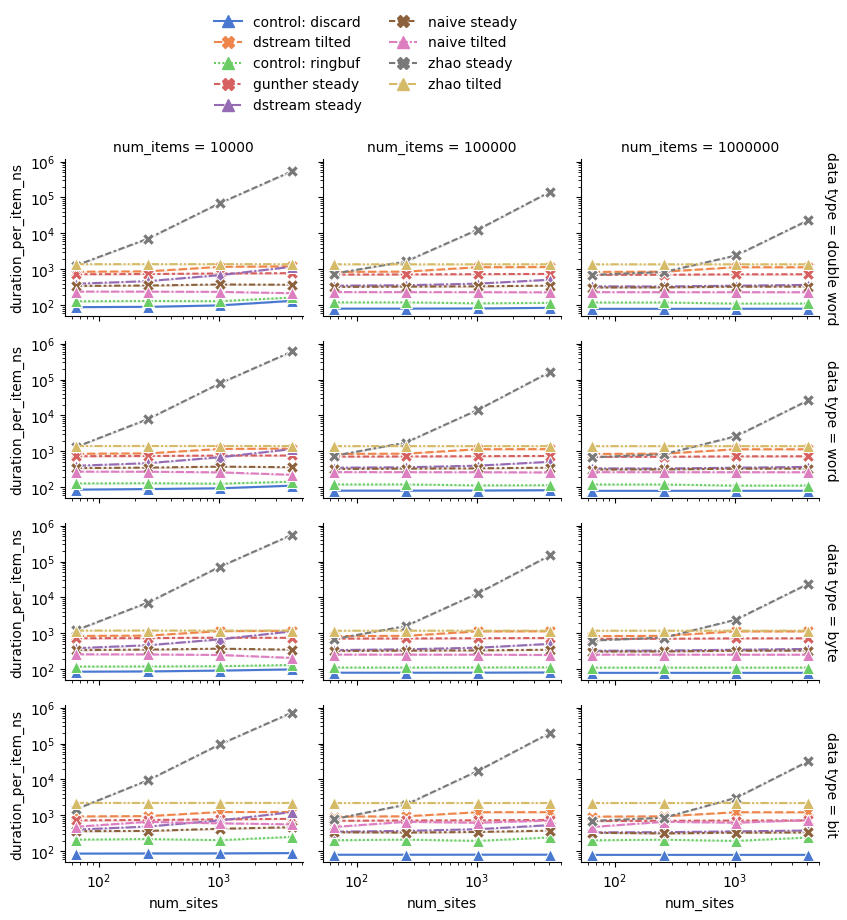

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: 
The markers list has fewer values (2) than needed (9) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-02-19-cpp-bench-speed-pico/col=num-items+font.family=serif+hue=algorithm+kind=line+palette=muted+row=data-type+style=algorithm+viz=relplot+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-02-19-cpp-bench-speed-pico/col=num-items+font.family=serif+hue=algorithm+kind=line+palette=muted+row=data-type+style=algorithm+viz=relplot+x=num-sites+y=duration-per-item-ns+ext=.pgf
teeplots/2025-02-19-cpp-bench-speed-pico/col=num-items+font.family=serif+hue=algorithm+kind=line+palette=muted+row=data-type+style=algorithm+viz=relplot+x=num-sites+y=duration-per-item-ns+ext=.png


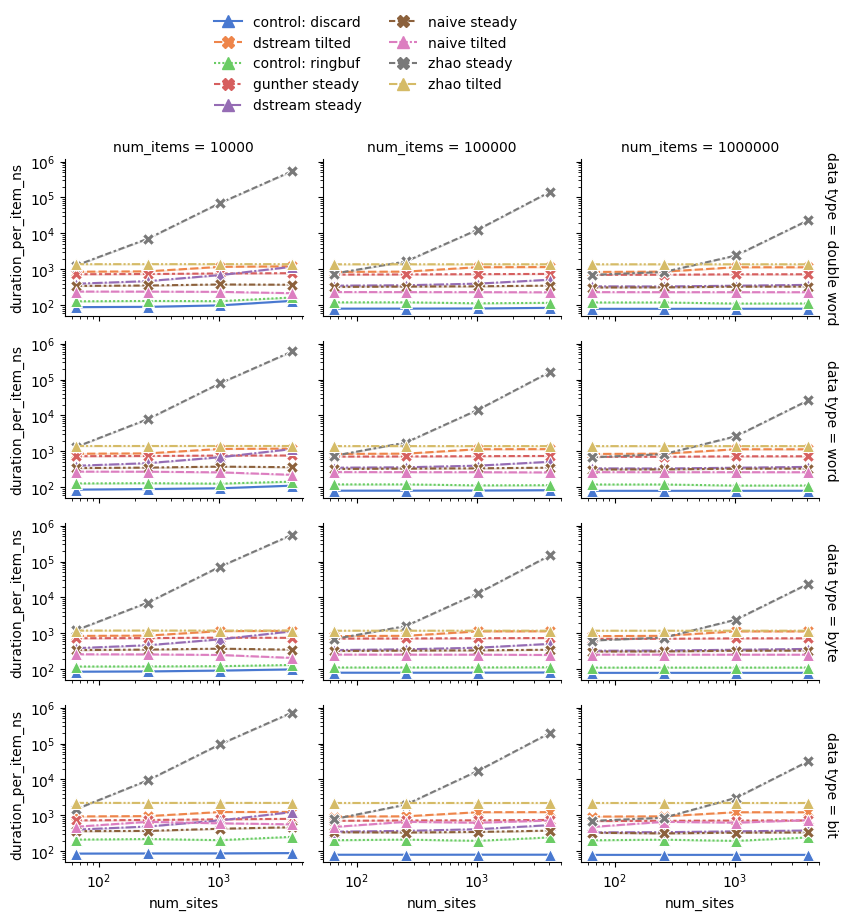

In [6]:
for rc in [{}, {"font.family": "serif"}]:
    with sns.plotting_context(rc=rc):
        with tp.teed(
            sns.relplot,
            data=df,
            x="num_sites",
            y="duration_per_item_ns",
            col="num_items",
            row="data type",
            hue="algorithm",
            style="algorithm",
            palette="muted",
            kind="line",
            aspect=1.5,
            markers=["^", "X"],
            ms=8,
            height=2,
            teeplot_outattrs=rc,
            teeplot_subdir=teeplot_subdir,
            facet_kws=dict(margin_titles=True),
        ) as g:
            g.set(xscale="log", yscale="log")
            sns.move_legend(
                g,
                "lower center",
                bbox_to_anchor=(0.35, 1),
                ncol=2,
                title=None,
                frameon=False,
            )
            g.tight_layout()


teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+hue=algorithm+kind=line+num_sites=64+palette=muted+style=algorithm+viz=relplot+x=num-items+y=duration-per-item-ns+ext=.pdf
teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+hue=algorithm+kind=line+num_sites=64+palette=muted+style=algorithm+viz=relplot+x=num-items+y=duration-per-item-ns+ext=.pgf
teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+hue=algorithm+kind=line+num_sites=64+palette=muted+style=algorithm+viz=relplot+x=num-items+y=duration-per-item-ns+ext=.png


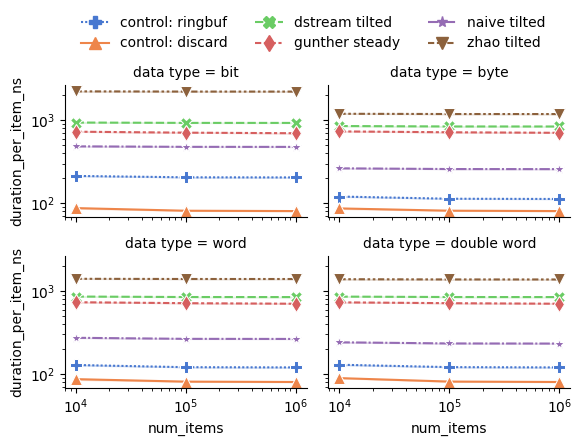

teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+hue=algorithm+kind=line+num_sites=256+palette=muted+style=algorithm+viz=relplot+x=num-items+y=duration-per-item-ns+ext=.pdf
teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+hue=algorithm+kind=line+num_sites=256+palette=muted+style=algorithm+viz=relplot+x=num-items+y=duration-per-item-ns+ext=.pgf
teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+hue=algorithm+kind=line+num_sites=256+palette=muted+style=algorithm+viz=relplot+x=num-items+y=duration-per-item-ns+ext=.png


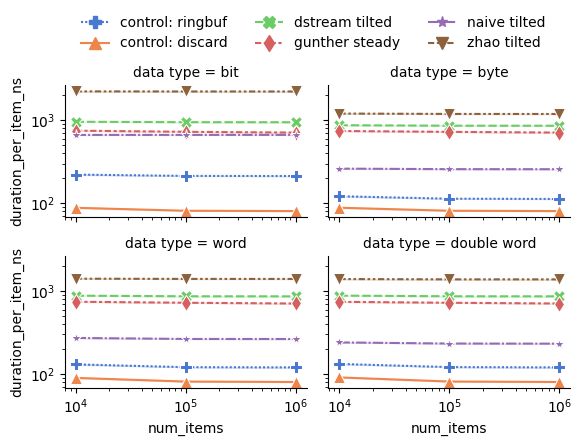

teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+hue=algorithm+kind=line+num_sites=1024+palette=muted+style=algorithm+viz=relplot+x=num-items+y=duration-per-item-ns+ext=.pdf
teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+hue=algorithm+kind=line+num_sites=1024+palette=muted+style=algorithm+viz=relplot+x=num-items+y=duration-per-item-ns+ext=.pgf
teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+hue=algorithm+kind=line+num_sites=1024+palette=muted+style=algorithm+viz=relplot+x=num-items+y=duration-per-item-ns+ext=.png


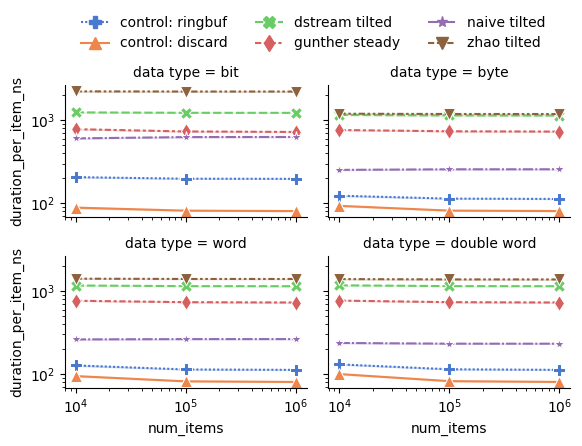

teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+hue=algorithm+kind=line+num_sites=4096+palette=muted+style=algorithm+viz=relplot+x=num-items+y=duration-per-item-ns+ext=.pdf
teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+hue=algorithm+kind=line+num_sites=4096+palette=muted+style=algorithm+viz=relplot+x=num-items+y=duration-per-item-ns+ext=.pgf
teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+hue=algorithm+kind=line+num_sites=4096+palette=muted+style=algorithm+viz=relplot+x=num-items+y=duration-per-item-ns+ext=.png


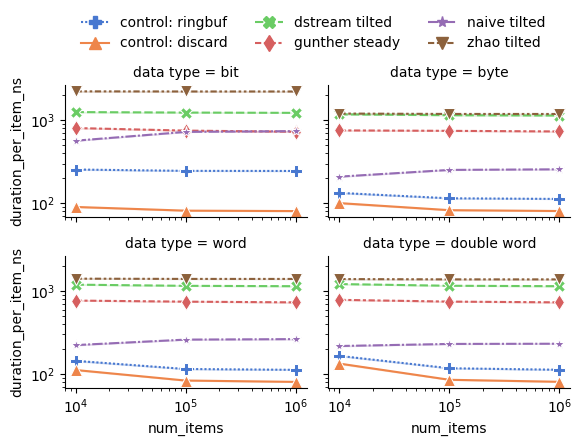

teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+font.family=serif+hue=algorithm+kind=line+num_sites=64+palette=muted+style=algorithm+viz=relplot+x=num-items+y=duration-per-item-ns+ext=.pdf
teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+font.family=serif+hue=algorithm+kind=line+num_sites=64+palette=muted+style=algorithm+viz=relplot+x=num-items+y=duration-per-item-ns+ext=.pgf
teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+font.family=serif+hue=algorithm+kind=line+num_sites=64+palette=muted+style=algorithm+viz=relplot+x=num-items+y=duration-per-item-ns+ext=.png


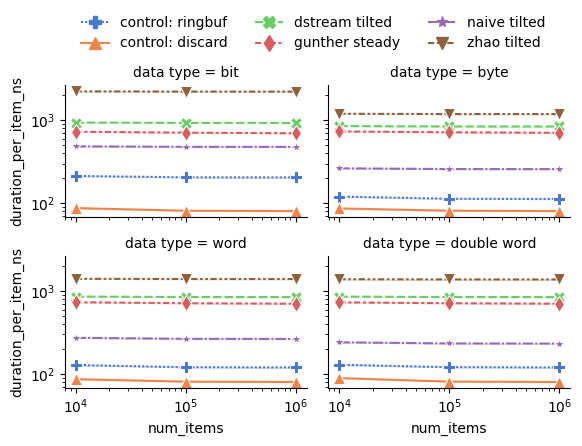

teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+font.family=serif+hue=algorithm+kind=line+num_sites=256+palette=muted+style=algorithm+viz=relplot+x=num-items+y=duration-per-item-ns+ext=.pdf
teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+font.family=serif+hue=algorithm+kind=line+num_sites=256+palette=muted+style=algorithm+viz=relplot+x=num-items+y=duration-per-item-ns+ext=.pgf
teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+font.family=serif+hue=algorithm+kind=line+num_sites=256+palette=muted+style=algorithm+viz=relplot+x=num-items+y=duration-per-item-ns+ext=.png


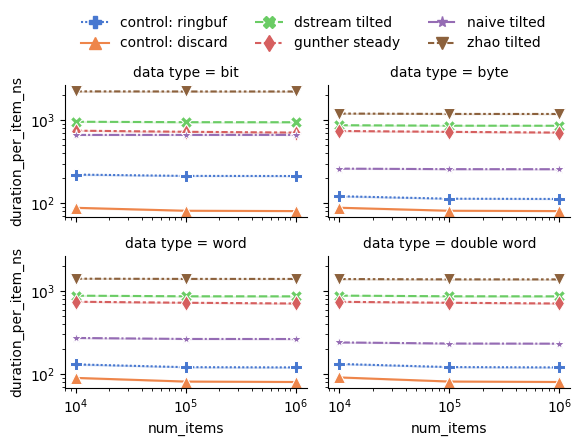

teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+font.family=serif+hue=algorithm+kind=line+num_sites=1024+palette=muted+style=algorithm+viz=relplot+x=num-items+y=duration-per-item-ns+ext=.pdf
teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+font.family=serif+hue=algorithm+kind=line+num_sites=1024+palette=muted+style=algorithm+viz=relplot+x=num-items+y=duration-per-item-ns+ext=.pgf
teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+font.family=serif+hue=algorithm+kind=line+num_sites=1024+palette=muted+style=algorithm+viz=relplot+x=num-items+y=duration-per-item-ns+ext=.png


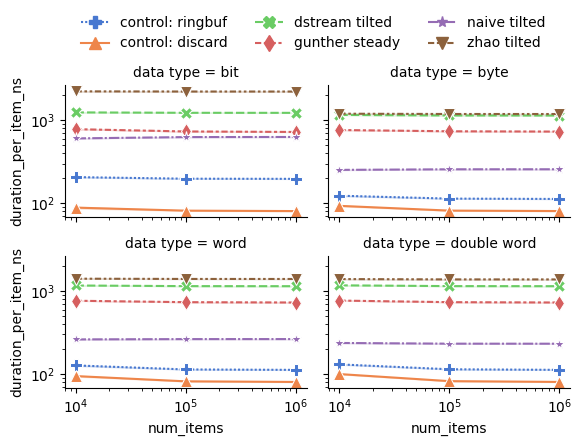

teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+font.family=serif+hue=algorithm+kind=line+num_sites=4096+palette=muted+style=algorithm+viz=relplot+x=num-items+y=duration-per-item-ns+ext=.pdf
teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+font.family=serif+hue=algorithm+kind=line+num_sites=4096+palette=muted+style=algorithm+viz=relplot+x=num-items+y=duration-per-item-ns+ext=.pgf
teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+font.family=serif+hue=algorithm+kind=line+num_sites=4096+palette=muted+style=algorithm+viz=relplot+x=num-items+y=duration-per-item-ns+ext=.png


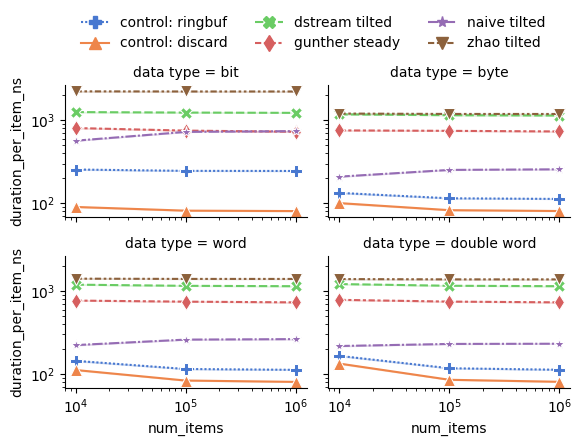

In [7]:
for rc in [{}, {"font.family": "serif"}]:
    with sns.plotting_context(rc=rc):
        for num_sites in [64, 256, 1024, 4096]:
            with tp.teed(
                sns.relplot,
                data=df.filter(
                    pl.col("algorithm").is_in(
                        [
                            "control: ringbuf",
                            "control: discard",
                            "dstream tilted",
                            "gunther steady",
                            "naive tilted",
                            "zhao tilted",
                        ],
                    ),
                    pl.col("num_sites") == num_sites,
                ),
                x="num_items",
                y="duration_per_item_ns",
                col="data type",
                col_wrap=2,
                col_order=[
                    "bit",
                    "byte",
                    "word",
                    "double word",
                ],
                hue="algorithm",
                hue_order=[
                    "control: ringbuf",
                    "control: discard",
                    "dstream tilted",
                    "gunther steady",
                    "naive tilted",
                    "zhao tilted",
                ],
                style="algorithm",
                palette="muted",
                kind="line",
                aspect=1.5,
                markers=["^", "X", "P", "d", "*", "v"],
                ms=8,
                height=2,
                teeplot_subdir=teeplot_subdir,
                facet_kws=dict(margin_titles=False),
                teeplot_outattrs={
                    "num_sites": num_sites,
                    **rc,
                },
            ) as g:
                g.set(xscale="log", yscale="log")
                sns.move_legend(
                    g,
                    "upper center",
                    bbox_to_anchor=(0.42, 1.12),
                    ncol=3,
                    title=None,
                    frameon=False,
                )
                g.tight_layout()


/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: 
The markers list has fewer values (2) than needed (6) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+hue=algorithm+kind=line+palette=muted+style=algorithm+viz=relplot+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+hue=algorithm+kind=line+palette=muted+style=algorithm+viz=relplot+x=num-sites+y=duration-per-item-ns+ext=.pgf
teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+hue=algorithm+kind=line+palette=muted+style=algorithm+viz=relplot+x=num-sites+y=duration-per-item-ns+ext=.png


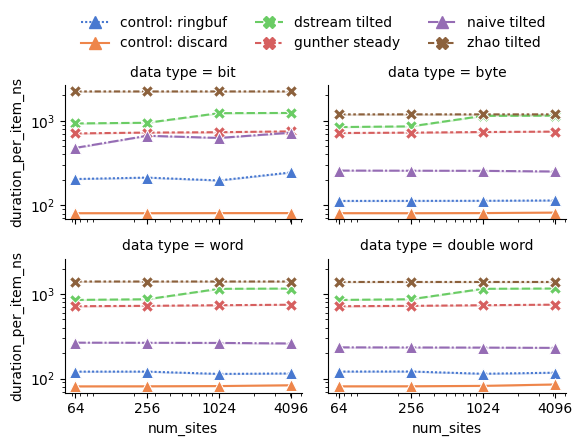

/usr/local/lib/python3.10/dist-packages/teeplot/teeplot.py:227: UserWarning: 
The markers list has fewer values (2) than needed (6) and will cycle, which may produce an uninterpretable plot.
  teed = plotter(*args, **{k: v for k, v in kwargs.items()})


teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+font.family=serif+hue=algorithm+kind=line+palette=muted+style=algorithm+viz=relplot+x=num-sites+y=duration-per-item-ns+ext=.pdf
teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+font.family=serif+hue=algorithm+kind=line+palette=muted+style=algorithm+viz=relplot+x=num-sites+y=duration-per-item-ns+ext=.pgf
teeplots/2025-02-19-cpp-bench-speed-pico/col=data-type+font.family=serif+hue=algorithm+kind=line+palette=muted+style=algorithm+viz=relplot+x=num-sites+y=duration-per-item-ns+ext=.png


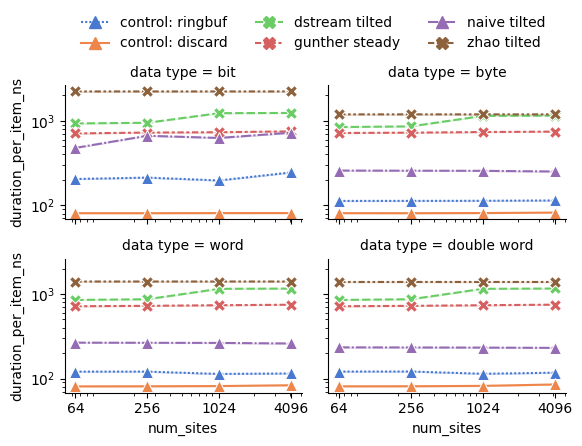

In [8]:
for rc in [{}, {"font.family": "serif"}]:
    with sns.plotting_context(rc=rc):
        with tp.teed(
            sns.relplot,
            data=df.filter(
                pl.col("algorithm").is_in(
                    [
                        "control: ringbuf",
                        "control: discard",
                        "dstream tilted",
                        "gunther steady",
                        "naive tilted",
                        "zhao tilted",
                    ],
                ),
                pl.col("num_items") == 100_000,
            ),
            x="num_sites",
            y="duration_per_item_ns",
            col="data type",
            col_wrap=2,
            col_order=[
                "bit",
                "byte",
                "word",
                "double word",
            ],
            hue="algorithm",
            hue_order=[
                "control: ringbuf",
                "control: discard",
                "dstream tilted",
                "gunther steady",
                "naive tilted",
                "zhao tilted",
            ],
            style="algorithm",
            palette="muted",
            kind="line",
            aspect=1.5,
            markers=["^", "X"],
            ms=8,
            height=2,
            teeplot_outattrs=rc,
            teeplot_subdir=teeplot_subdir,
            facet_kws=dict(margin_titles=False),
        ) as g:
            g.set(xscale="log", yscale="log")
            sns.move_legend(
                g,
                "upper center",
                bbox_to_anchor=(0.42, 1.12),
                ncol=3,
                title=None,
                frameon=False,
            )
            for ax in g.axes.flat:
                ax.set_xticks([64, 256, 1024, 4096])
                ax.set_xticklabels(["64", "256", "1024", "4096"])
            g.tight_layout()


In [9]:
# # 1) Compute mean duration per group x algo
# df_agg = df.group_by(
#     ["compiler", "num_items", "num_sites", "replicate", "algo_name", "data type"]
# ).agg(mean_duration_s=pl.col("duration_s").mean())

# # 2) Compute mean duration *just for* "naive_steady_algo"
# df_naive = (
#     df.filter(pl.col("algo_name") == "naive_steady_algo")
#     .group_by(["compiler", "num_items", "num_sites", "replicate", "data type"])
#     .agg(naive_mean_duration_s=pl.col("duration_s").mean())
# )


# # 3) Join the two on compiler,num_items,num_sites,replicate
# df_speedup = df_agg.join(
#     df_naive,
#     on=["compiler", "num_items", "num_sites", "replicate", "data type"],
#     how="left",
# ).with_columns(
#     (pl.lit(1_000_000_000) * pl.col("mean_duration_s") / pl.col("num_items"))
#     .alias("ns_per_op"),
#     # 4) Speedup = ratio vs. naive_steady_algo
#     (pl.col("naive_mean_duration_s") / pl.col("mean_duration_s")).alias(
#         "speedup"
#     )
# )

# # Display tabular results
# with pd.option_context("display.max_columns", None):
#     with pd.option_context("display.max_rows", None):
#         display(
#             df_speedup.filter(pl.col("num_items") == 1_000_000)
#             .group_by(["num_sites", "algo_name", "data type"])
#             .agg(
#                 speedup_mean=pl.col("speedup").mean(),
#                 speedup_std=pl.col("speedup").std(),
#                 ns_per_op_mean=pl.col("ns_per_op").mean(),
#                 ns_per_op_std=pl.col("ns_per_op").std(),
#             )
#             .sort(["algo_name", "num_sites"])
#             .to_pandas()
#         )

# # Display tabular results
# with pd.option_context("display.max_columns", None):
#     with pd.option_context("display.max_rows", None):
#         display(
#             df_speedup.filter(pl.col("num_items") == 10_000)
#             .group_by(["num_sites", "algo_name", "data type"])
#             .agg(
#                 speedup_mean=pl.col("speedup").mean(),
#                 speedup_std=pl.col("speedup").std(),
#                 ns_per_op_mean=pl.col("ns_per_op").mean(),
#                 ns_per_op_std=pl.col("ns_per_op").std(),
#             )
#             .sort(["algo_name", "num_sites", "data type"])
#             .to_pandas()
#         )

# # Now plot speedup on a log scale
# with tp.teed(
#     sns.catplot,
#     data=df_speedup.cast({"num_sites": str}).filter(
#         pl.col("algo_name") != "naive_steady_algo"
#     ),
#     x="num_sites",
#     y="speedup",
#     order=list(map(str, sorted(df["num_sites"].unique()))),
#     hue="algo_name",
#     col="compiler",
#     row="data type",
#     kind="bar",
#     aspect=1.4,
#     height=2.5,
#     teeplot_subdir=teeplot_subdir,
# ) as g:
#     g.set(yscale="log", ylim=(1, None))
#     for ax in g.axes.flat:
#         ax.bar_label(
#             ax.containers[1],
#             fmt="$%d\\times$",
#             label_type="center",
#             rotation=90,
#         )
